# **Medical Cost Personal Datasets**
Insurance Forecast: The aim is to accurately predict insurance costs.

# **Data Description**

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


**Importing datasets**

In [2]:
# Importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, median_absolute_error, accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


In [92]:
# Changing the path to point to data location
filepath = "/content/drive/MyDrive/Portfolio_2024/insurance.csv"
# Reading the CSV file into a Pandas DataFrame
data = pd.read_csv(filepath)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Exploratory Data Analysis**

In [17]:
# Checking number of rows and columns
data.shape

(1338, 7)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [65]:
# Checking for duplicates
data.duplicated().sum()

1

In [93]:
# Dropping duplicate values
data.drop_duplicates(keep= 'first', inplace=True)

In [ ]:
# Checking % of na values in each column
(data.isna().mean().mul(100).pipe(lambda ser: ser[ser > 0]))

Series([], dtype: float64)

In [94]:
# Getting column names that have categorical and numerical data separately
def col_names(df):
    # Getting categorical Variables
    cat_cols = [col for col in df.columns if df[col].dtypes not in ["int64", "float64"]]
    # Getting numerical Variables
    num_cols = [col for col in df.columns if df[col].dtypes in ["int64", "float64"]]
    # Getting Numerical but Categorical Variables
    num_but_cat = [col for col in num_cols if df[col].nunique() < 10]
    # Adding num_but_cat to cat_cols
    cat_cols = num_but_cat + cat_cols
    # num_but_cat removing from num_cols
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Numerical Cols: {num_cols} \nCategorical Cols: {cat_cols} \nNumerical but Categorical: {num_but_cat}")
    return num_cols, cat_cols

In [95]:
numerical_cols, categorical_cols = col_names(data)

Numerical Cols: ['age', 'bmi', 'charges'] 
Categorical Cols: ['children', 'sex', 'smoker', 'region'] 
Numerical but Categorical: ['children']


**Analysing Numerical Attributes**

In [ ]:
data[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


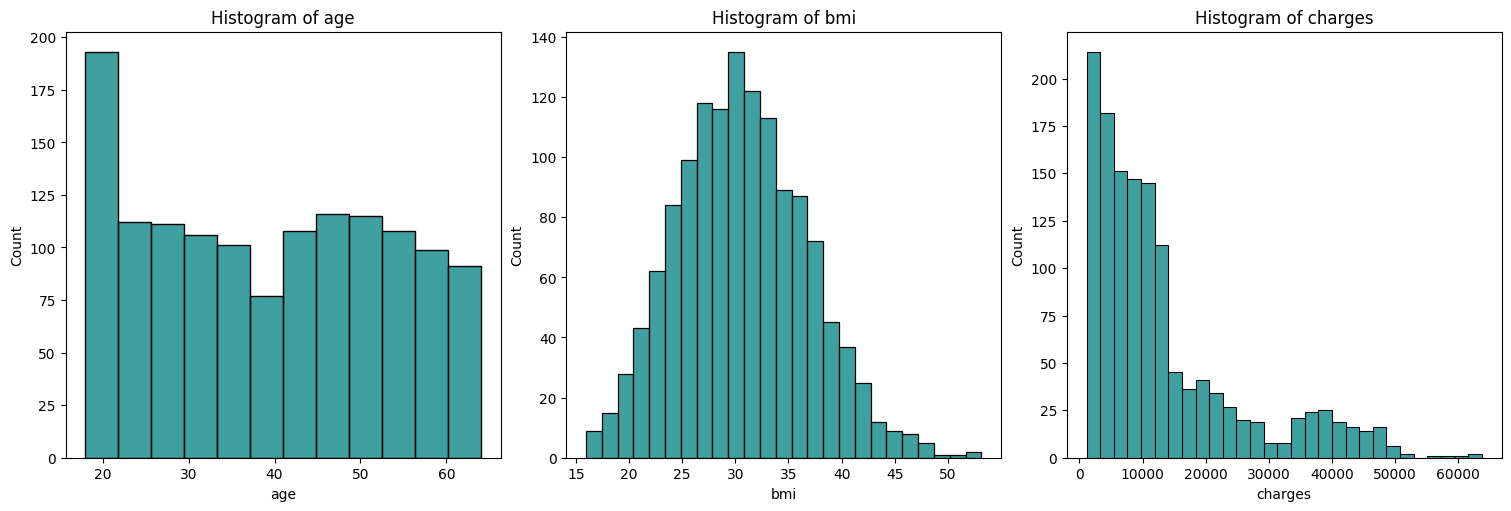

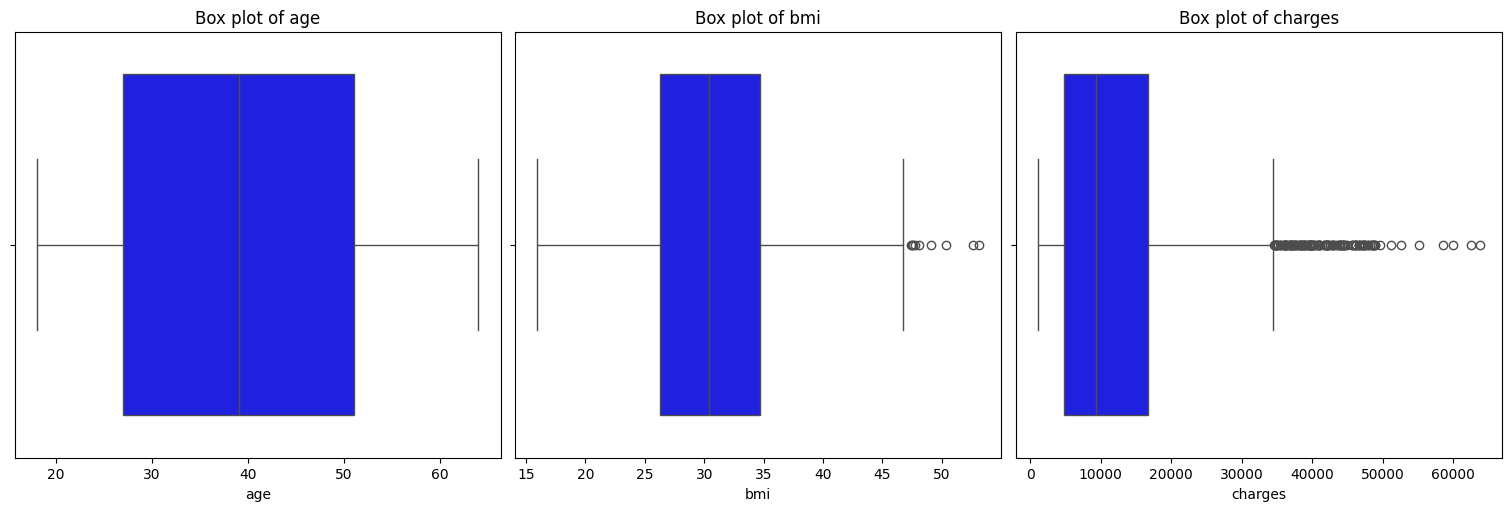

In [90]:
# Number of subplots
n_cols = len(numerical_cols)
# Creating the figure and axes
fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5), constrained_layout=True)
# Plotting histograms for each numerical column
for i, col in enumerate(numerical_cols):
    sns.histplot(x=data[col], data=data, color="teal", ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
plt.show()

# Checking for outliers
# Number of subplots
n_cols = len(numerical_cols)
# Creating the figure and axes
fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5), constrained_layout=True)
# Plotting box plots for each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=data[col], data=data, color="blue", ax=axes[i])
    axes[i].set_title(f'Box plot of {col}')
plt.show()

* The customer **ages** range from **18** to **64**, with an average age of **39**.
* The **average** **BMI** is 30, classifying the group as **obese class I**, with individual BMIs ranging from 16 (underweight) to 53 (obese class III).
* The **charges** vary widely, from $1,122 to $63,770, with an **average charge of $13,270**.

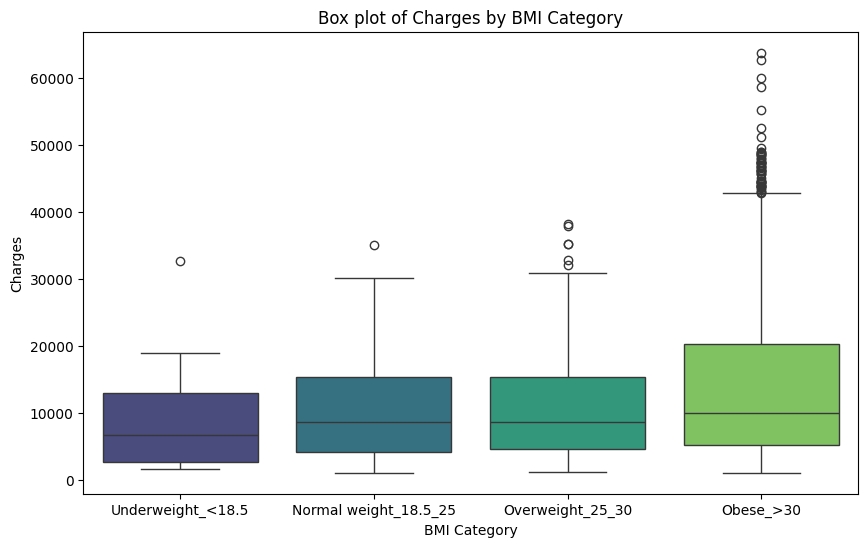

In [96]:
# BMI vs Charges
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight_<18.5'
    elif 18.5 <= bmi < 25:
        return 'Normal weight_18.5_25'
    elif 25 <= bmi < 30:
        return 'Overweight_25_30'
    else:
        return 'Obese_>30'

def bmi_with_charges(data):
    data['bmi_category'] = data['bmi'].apply(categorize_bmi)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x='bmi_category', y='charges', order=['Underweight_<18.5', 'Normal weight_18.5_25', 'Overweight_25_30', 'Obese_>30'], palette="viridis")
    plt.title('Box plot of Charges by BMI Category')
    plt.xlabel('BMI Category')
    plt.ylabel('Charges')
    plt.show()

bmi_with_charges(data)
data = data.drop(columns =['bmi_category'])


The World Health Organization classifies adult BMI into categories: underweight (below 18.5 kg/m²), normal weight (18.5 to 24.9), overweight (25 to 29.9), and obese (30 or more).

The boxplots above clearly demonstrate that the charges increase from underweight to obese categories. This suggests a discernible effect of BMI on charges.


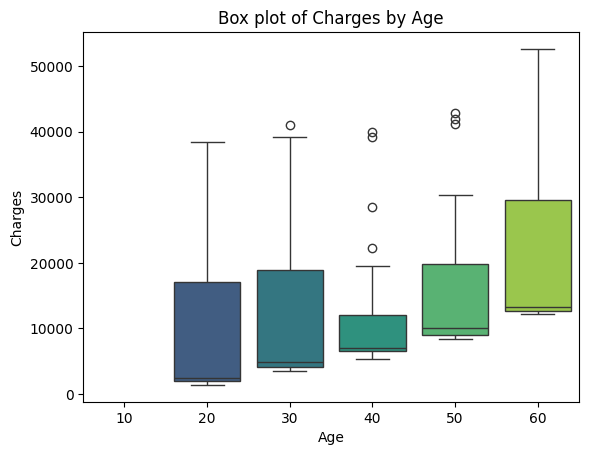

In [98]:
# Age vs Charges
sns.boxplot(data=data, x='age', y='charges',order=[10, 20, 30, 40, 50, 60], palette="viridis")
plt.title('Box plot of Charges by Age')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

The figure above illustrates a clear trend where charges increase with age.

**Analysing Categorical Attributes**

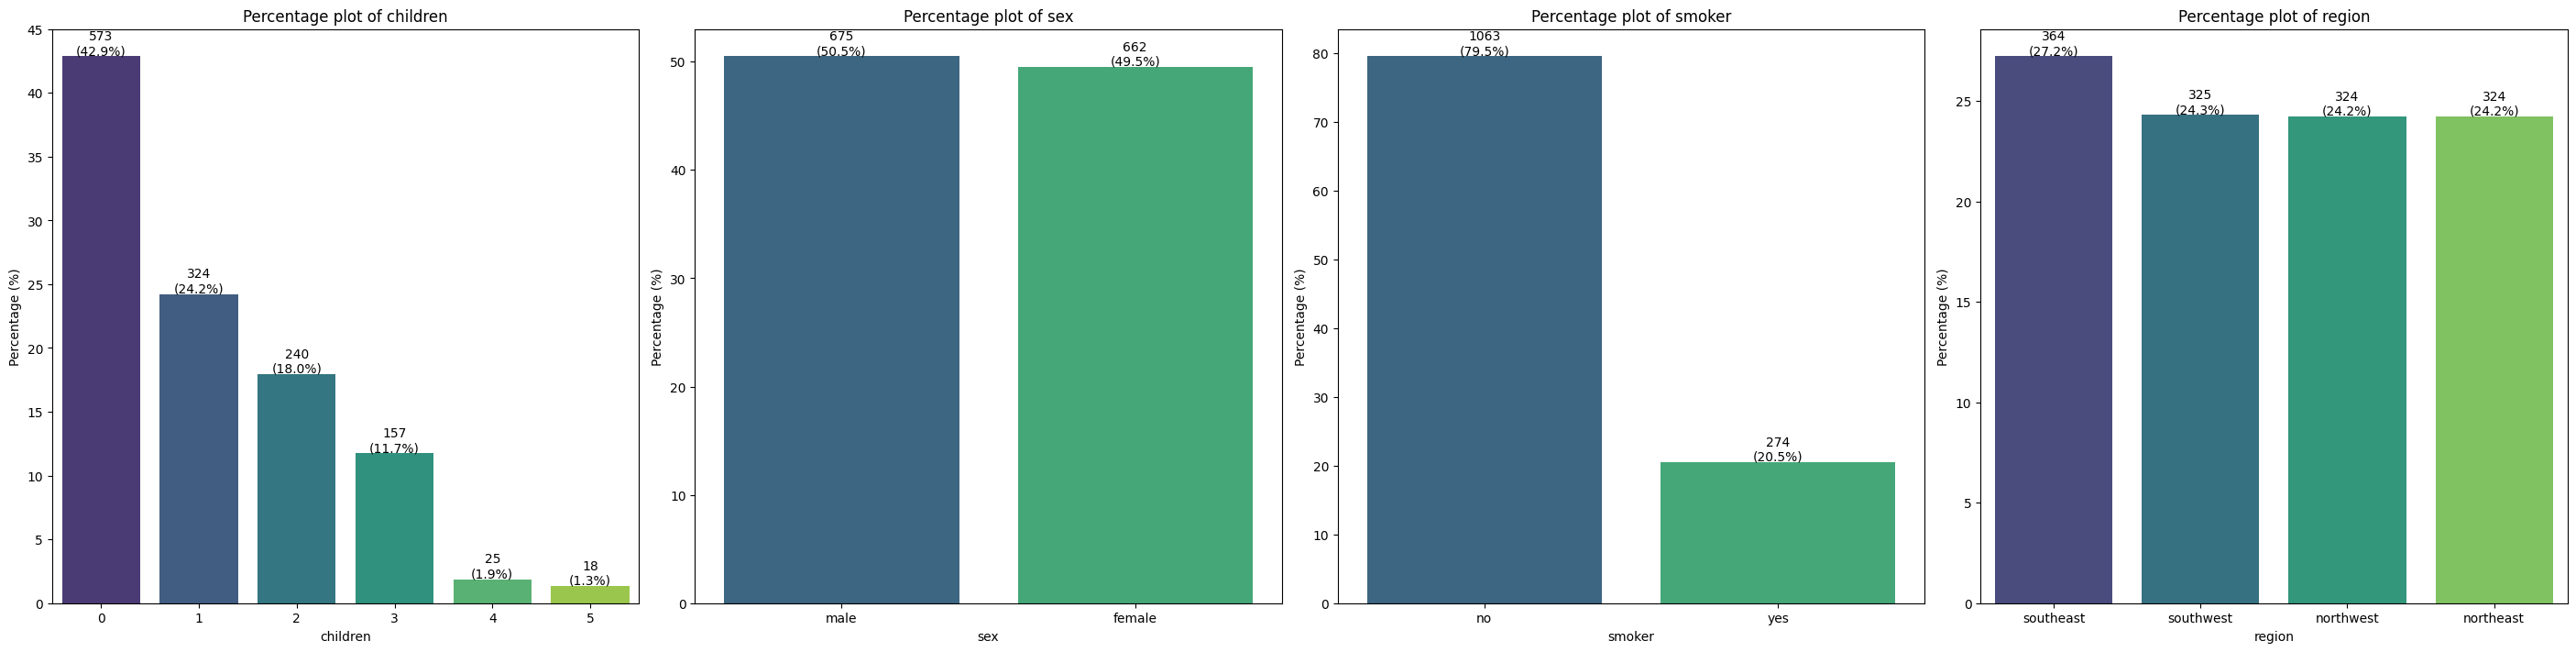

In [99]:
# Number of subplots
n_cols = len(categorical_cols)

# Creating the figure and axes
fig, axes = plt.subplots(1, n_cols, figsize=(7 * n_cols, 7), constrained_layout=True)

# Plotting bar plots for each categorical column
for i, col in enumerate(categorical_cols):
    # Calculate the percentage
    value_counts = data[col].value_counts()
    percentages = value_counts / value_counts.sum() * 100

    # Create a bar plot with percentages
    bar_plot = sns.barplot(x=percentages.index, y=percentages.values, palette="viridis", ax=axes[i])
    axes[i].set_title(f'Percentage plot of {col}')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel(col)

    # Adding the number of each value on top of the bars
    for p, count in zip(bar_plot.patches, value_counts):
        height = p.get_height()
        bar_plot.annotate(f'{count}\n({height:.1f}%)', (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()


* **Forty-three** percent of people have **no children**, while 24% have one child. The percentage of people with more than one child decreases, reaching as low as 1.3% for those with five children.

* The percentage of men is slightly higher than that of women, with **men** comprising **51%** of the population.

* The percentage of **non-smokers** is significantly high, at **80%**.

* The percentage of people from the Southwest, Northwest, and Northeast regions is almost the **same**. The **Southeast** has a **slightly higher** representation, with 27.2% of the people.

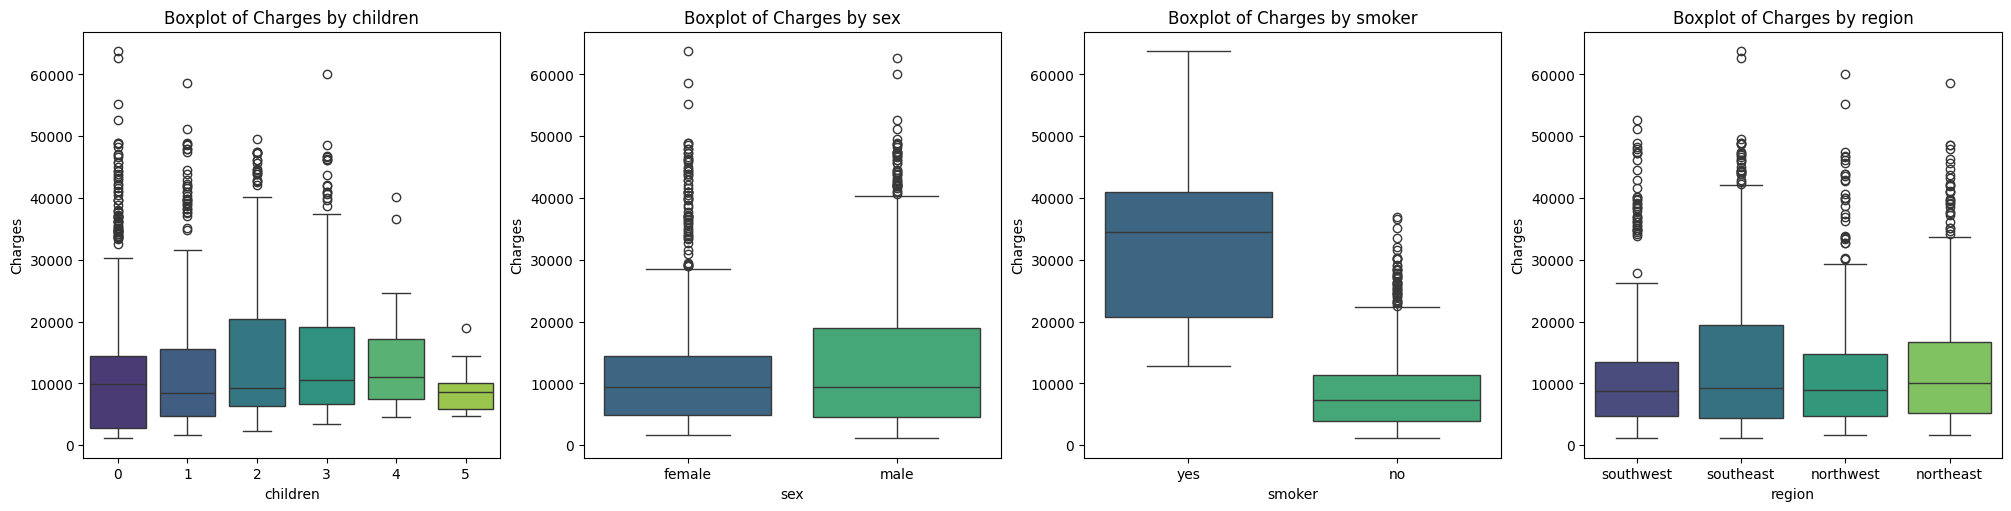

In [100]:
# Charges vs categorical variables: checking for outliers
def visualize_categorical_with_charges(data, categorical_cols):
    n_cols = len(categorical_cols)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5), constrained_layout=True)

    for i, col in enumerate(categorical_cols):
        sns.boxplot(x=data[col], y=data['charges'], palette="viridis", ax=axes[i])
        axes[i].set_title(f'Boxplot of Charges by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Charges')

    plt.show()

categorical_cols = ['children', 'sex', 'smoker', 'region']
visualize_categorical_with_charges(data, categorical_cols)

It's pretty clear that smokers have higher charges than non-smokers.

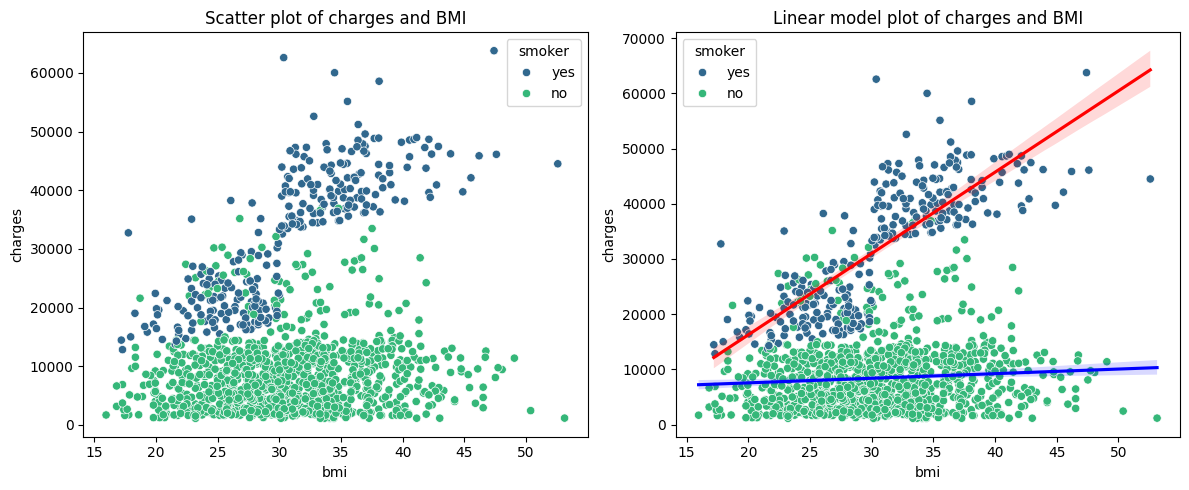

In [101]:
# Creating the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scattering plot of charges and BMI with hue for smoker status
sns.scatterplot(x='bmi', y='charges', data=data, palette='viridis', hue='smoker', ax=ax[0])
ax[0].set_title('Scatter plot of charges and BMI')

# Linear model plot of charges and BMI with hue for smoker status
sns.scatterplot(x='bmi', y='charges', data=data, palette='viridis', hue='smoker', ax=ax[1])
sns.regplot(x='bmi', y='charges', data=data[data['smoker'] == 'yes'], scatter=False, color='r', ax=ax[1])
sns.regplot(x='bmi', y='charges', data=data[data['smoker'] == 'no'], scatter=False, color='b', ax=ax[1])
ax[1].set_title('Linear model plot of charges and BMI')

plt.tight_layout()
plt.show()

**Data Preparation**

In [102]:
# Applying label encoder to binary columns (nunique values <2)
binary_cols = [col for col in data.columns if data[col].dtype not in ["int64", "float64"] and data[col].nunique() == 2]
binary_cols

['sex', 'smoker']

In [103]:
le = LabelEncoder()
for col in binary_cols:
    data[col] = le.fit_transform(data[col])

In [104]:
# Converting region column into numerical
data['region'] = le.fit_transform(data['region'])

In [105]:
# Feature Scalling: Applying Min-Max Scaler to "age" and "bmi"
sc = MinMaxScaler()
data["age"] = sc.fit_transform(data[["age"]])
data["bmi"] = sc.fit_transform(data[["bmi"]])

In [106]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,0.021739,0,0.321227,0,1,3,16884.92400
1,0.000000,1,0.479150,1,0,2,1725.55230
2,0.217391,1,0.458434,3,0,2,4449.46200
3,0.326087,1,0.181464,0,0,1,21984.47061
4,0.304348,1,0.347592,0,0,1,3866.85520


**Checking for correllation**

<Axes: >

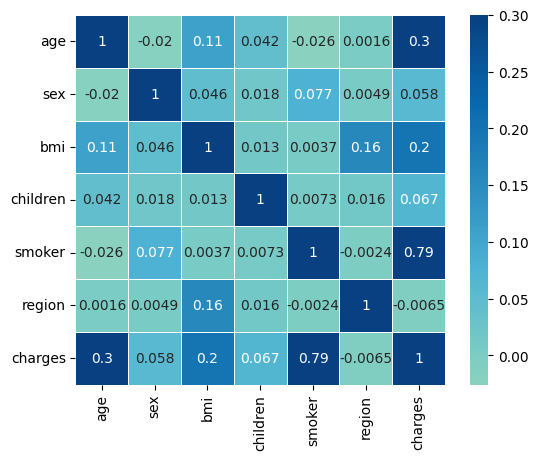

In [107]:
corr = data.corr()
sns.heatmap(corr, cmap="GnBu", vmax=.3, center=0, square=True, annot=True, linewidths=0.5,)

**Model Building**

In [108]:
# Features and target
X = data.drop('charges', axis=1)
y = data['charges']

In [109]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
# Defining the models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(random_state=42),
    'Ridge Regression': Ridge(random_state=42),
    'PolynomialRegression': Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())]),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

In [111]:
# Function to print metrics
def print_metrics(name, rmse_mean, rmse_std):
    print(f'{name}:')
    print(f'  RMSE Mean: {rmse_mean:.2f}')
    print(f'  RMSE Std Dev: {rmse_std:.2f}\n')

# Evaluating models using cross-validation
for name, model in models.items():
    if isinstance(model, Pipeline):
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    else:
        scores = cross_val_score(model, X_train, y_train.ravel(), cv=5, scoring='neg_mean_squared_error')

    rmse_scores = np.sqrt(-scores)
    print_metrics(name, np.mean(rmse_scores), np.std(rmse_scores))

# Selecting best model based on cross-validation scores
best_model_name = min(models, key=lambda x: np.mean(np.sqrt(-cross_val_score(models[x], X_train, y_train.ravel(), cv=5, scoring='neg_mean_squared_error'))))

# Training best model on full training set
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# Evaluating best model on test set
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Best Model: {best_model_name}')
print(f'Test RMSE for {best_model_name}: {test_rmse:.2f}')

Linear Regression:
  RMSE Mean: 6113.10
  RMSE Std Dev: 391.56

Lasso Regression:
  RMSE Mean: 6113.01
  RMSE Std Dev: 391.45

Ridge Regression:
  RMSE Mean: 6113.04
  RMSE Std Dev: 391.53

PolynomialRegression:
  RMSE Mean: 4892.74
  RMSE Std Dev: 428.40

Decision Tree:
  RMSE Mean: 6886.38
  RMSE Std Dev: 353.32

Random Forest:
  RMSE Mean: 5008.25
  RMSE Std Dev: 335.60

XGBoost:
  RMSE Mean: 5452.13
  RMSE Std Dev: 298.07

Best Model: PolynomialRegression
Test RMSE for PolynomialRegression: 4564.67


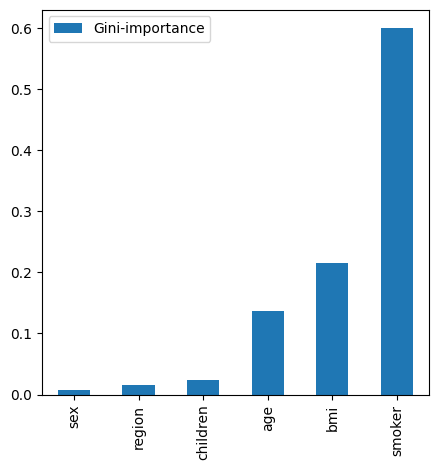

In [112]:
# Measuring the importance of each feature using Random forest - Gini importance
feature_names = [f"feature {i}" for i in range ((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold feature_name:feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
  feats[feature] = importance # add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(5,5))
plt.show()

In [113]:
# Dropping features with low importance and training again
X = data.drop(columns = ['charges', 'sex'], axis=1)
y = data['charges']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
# Training best model on full training set
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# Evaluating best model on test set
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Best Model: {best_model_name}')
print(f'Test RMSE for {best_model_name}: {test_rmse:.2f}')

Best Model: PolynomialRegression
Test RMSE for PolynomialRegression: 4553.72
